# ESOL Model 2: 
GraphSAGE

In [6]:
import rdkit
from torch_geometric.datasets import MoleculeNet

data = MoleculeNet(root='data/ESOL', name='ESOL')

In [7]:
import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.convs = torch.nn.ModuleList([
            SAGEConv(
                data.num_features if i == 0 else embedding_size,
                embedding_size)
            for i in range(4)
        ])

        self.out = Linear(embedding_size, 1)
    def forward(self, x, edge_index, batch_index):
        hidden = x
        for conv in self.convs:
            hidden = conv(hidden, edge_index)
            hidden = F.relu(hidden)

        hidden = gap(hidden, batch_index)
        out = self.out(hidden)
        return out, hidden

model = GraphSAGE()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GraphSAGE(
  (convs): ModuleList(
    (0): SAGEConv(9, 64, aggr=mean)
    (1-3): 3 x SAGEConv(64, 64, aggr=mean)
  )
  (out): Linear(in_features=64, out_features=1, bias=True)
)
Number of parameters:  26049


In [8]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train():
    for batch in loader:
      batch.to(device)  
      optimizer.zero_grad()
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      loss = loss_fn(pred, batch.y) 
      loss.backward()  
      optimizer.step()
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train()
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 26.44060516357422
Epoch 100 | Train Loss 0.6733148694038391
Epoch 200 | Train Loss 1.4461860656738281
Epoch 300 | Train Loss 0.23865906894207
Epoch 400 | Train Loss 0.0849025547504425
Epoch 500 | Train Loss 0.11334141343832016
Epoch 600 | Train Loss 0.46055248379707336
Epoch 700 | Train Loss 0.19582724571228027
Epoch 800 | Train Loss 0.19601885974407196
Epoch 900 | Train Loss 0.07870209962129593
Epoch 1000 | Train Loss 0.06959208846092224
Epoch 1100 | Train Loss 0.38634422421455383
Epoch 1200 | Train Loss 0.19568194448947906
Epoch 1300 | Train Loss 0.03805892542004585
Epoch 1400 | Train Loss 0.05001900717616081
Epoch 1500 | Train Loss 0.11530300229787827
Epoch 1600 | Train Loss 0.06341526657342911
Epoch 1700 | Train Loss 0.37765324115753174
Epoch 1800 | Train Loss 0.01664232462644577
Epoch 1900 | Train Loss 0.12541596591472626


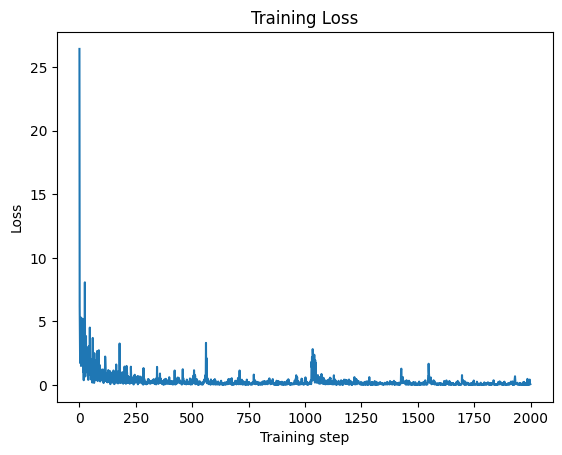

RMSE: 0.854
MAE: 0.633
R²: 0.822
Pearson correlation: 0.911 (p-value: 4.842e-88)


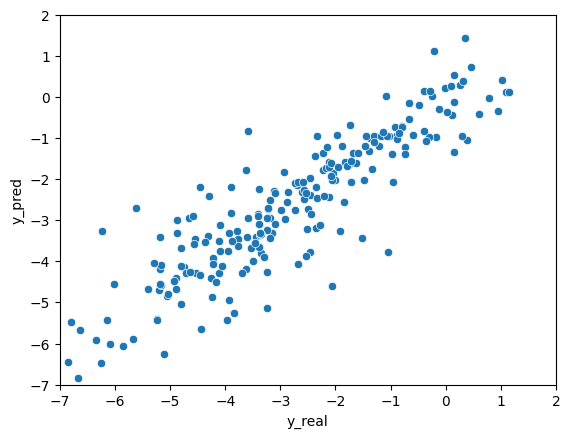

In [9]:
from master_functions import visualize_losses

visualize_losses(losses)

from master_functions import model_eval

model_eval(model, test_loader, device)